# Convert a picture dataset using ESIM - part 2/2

This serie of notebooks is an example of how to convert a picture dataset using RPG ESIM (available: https://github.com/uzh-rpg/rpg_esim), a ROS-based event camera simulator developed by the Robotic Perception Group (UZH).

The choosen dataset is "IBERBIRDS: A dataset of flying bird species present in the Iberian Peninsula" (available: https://zenodo.org/records/15090760), whose pictures were reorganized in order to have a single folder for every specie. There is a total of 4000 pictures divided in 10 folders (one for each specie). 

*Please select Kernel → Python 3 before proceeding.*

In this notebook, the BAG files obtained in the first part will be converted in AEDAT files.

In [1]:
import os
import struct
import shutil
import pandas as pd
import numpy as np
from bagpy import bagreader
from pyNAVIS import SpikesFile, Savers, MainSettings

settings = MainSettings(num_channels=1, address_size=4, timestamp_size=4, ts_tick=1)

def parse_events_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    if 'events' not in df.columns:
        raise ValueError("The 'events' column is missing in the CSV.")

    x_coords, y_coords, timestamps, polarities = [], [], [], []

    for row in df['events']:
        raw_events = row.split(", ")
        for ev in raw_events:
            if 'x:' in ev:
                try:
                    x = int(ev.split("x:")[1].split("\n")[0].strip())
                    y = int(ev.split("y:")[1].split("\n")[0].strip())
                    sec = int(ev.split("secs:")[1].split("\n")[0].strip())
                    nsec = int(ev.split("nsecs:")[1].split("\n")[0].strip())
                    ts = sec * 1e6 + nsec // 1000  # microseconds
                    pol = 'True' in ev
                    x_coords.append(x)
                    y_coords.append(y)
                    timestamps.append(int(ts))
                    polarities.append(pol)
                except Exception as e:
                    print(f"An error occurred while parsing event: {e}")
                    continue

    if not x_coords:
        raise ValueError("No parsed events found in CSV.")

    x_coords_np = np.array(x_coords, dtype=np.uint16)
    y_coords_np = np.array(y_coords, dtype=np.uint16)
    timestamps_np = np.array(timestamps, dtype=np.int64)
    polarities_np = np.array(polarities, dtype=bool)

    return x_coords_np, y_coords_np, timestamps_np, polarities_np

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


### Watch and save the events obtained from a single picture

The script below processes a single picture (defined using the frame path). It shows the histograms obtained integrating both by events and by times, then saves the AEDAT file and deletes the BAG file. In the first block, the needed functions to create the histograms can be found.

In [2]:
import matplotlib.pyplot as plt

def integrate_by_events(x_coords, y_coords, polarities, block_size, img_size):
    num_blocks = len(x_coords) // block_size + (1 if len(x_coords) % block_size else 0)
    histograms = []
    for b in range(num_blocks):
        start = b * block_size
        end = min((b+1)*block_size, len(x_coords))
        hist = np.zeros((img_size, img_size), dtype=np.int32)
        for x, y, p in zip(x_coords[start:end], y_coords[start:end], polarities[start:end]):
            hist[y, x] += 1 if p else -1 
        histograms.append(hist)
        # visualization 
        plt.imshow(hist, cmap='bwr', vmin=-np.max(np.abs(hist)), vmax=np.max(np.abs(hist)))
        plt.title(f'Events block {b+1}')
        plt.colorbar()
        plt.show()
    return histograms

def integrate_by_time(timestamps, x_coords, y_coords, polarities, interval_us, img_size):
    start_ts = timestamps[0]
    end_ts = timestamps[-1]
    histograms = []
    current_start = start_ts
    current_end = current_start + interval_us
    idx_start = 0
    n = len(timestamps)
    while current_start <= end_ts:
        hist = np.zeros((img_size, img_size), dtype=np.int32)
        idx_end = idx_start
        while idx_end < n and timestamps[idx_end] < current_end:
            x, y, p = x_coords[idx_end], y_coords[idx_end], polarities[idx_end]
            hist[y, x] += 1 
            idx_end += 1
        histograms.append(hist)
        # visualization 
        plt.imshow(hist, cmap='hot')
        plt.title(f'Time block {current_start} - {current_end} us')
        plt.colorbar()
        plt.show()
        current_start = current_end
        current_end += interval_us
        idx_start = idx_end
    return histograms

[INFO]  Data folder /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_1/out already exists. Not creating.


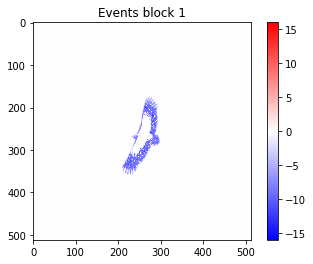

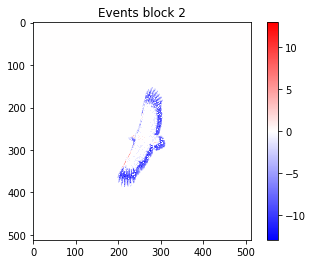

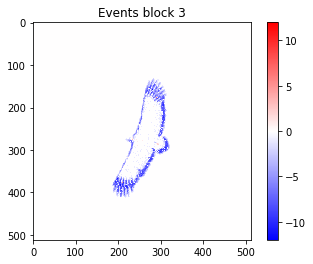

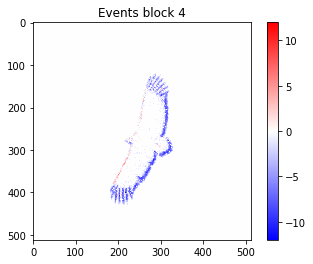

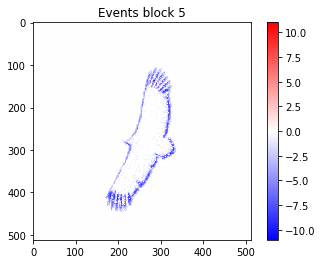

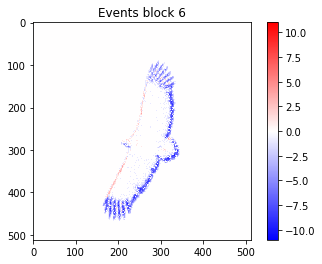

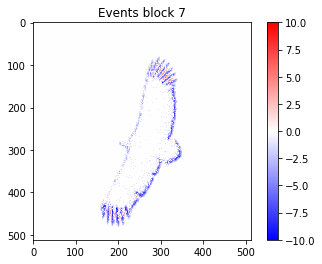

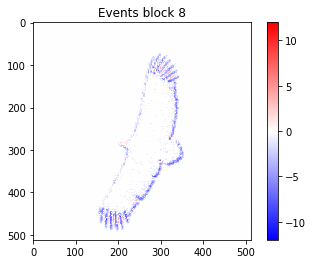

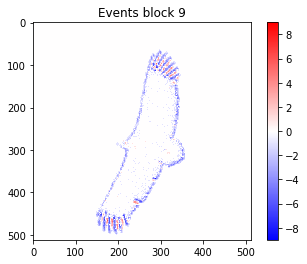

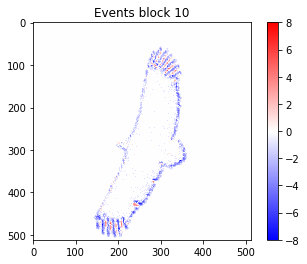

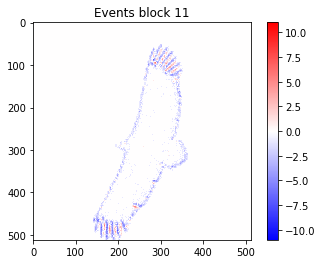

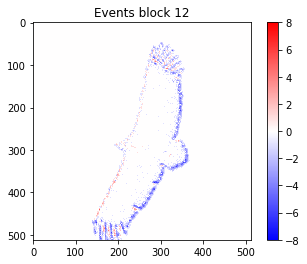

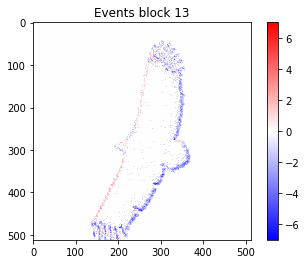

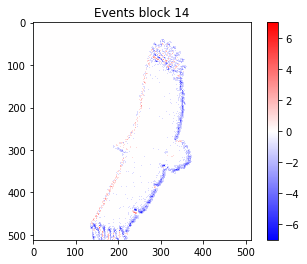

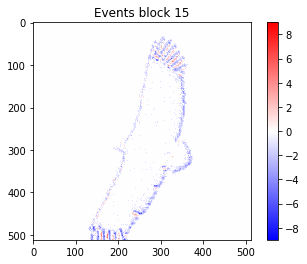

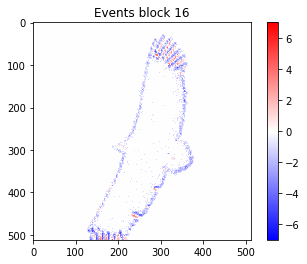

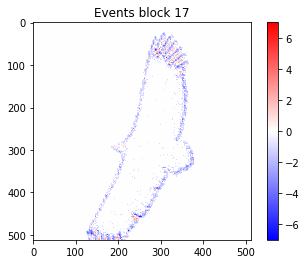

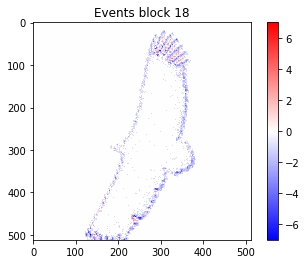

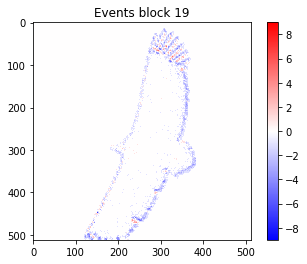

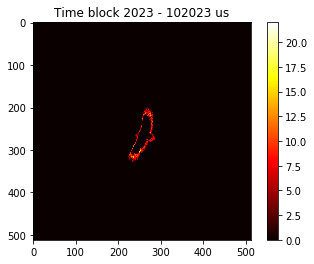

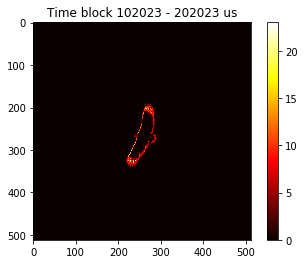

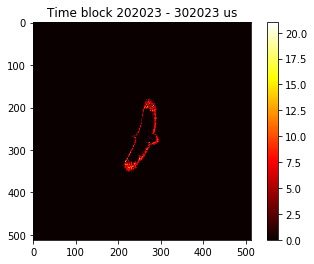

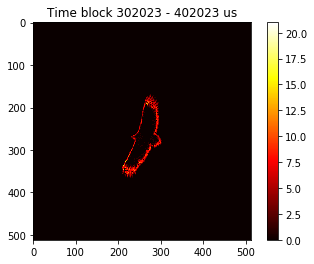

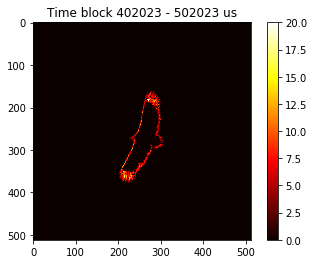

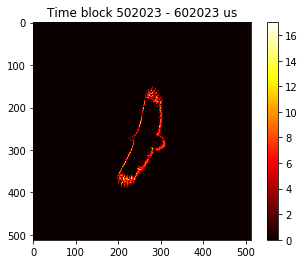

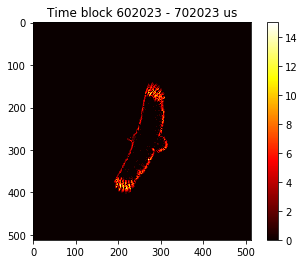

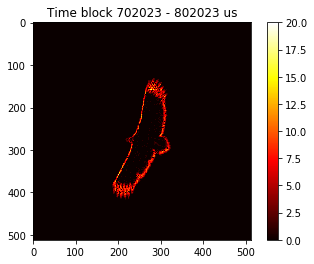

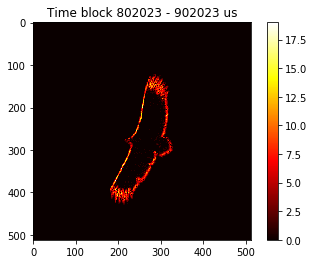

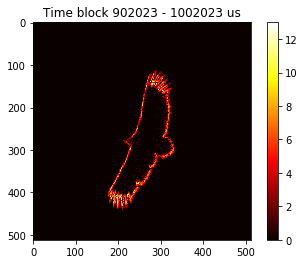

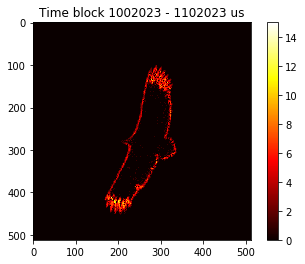

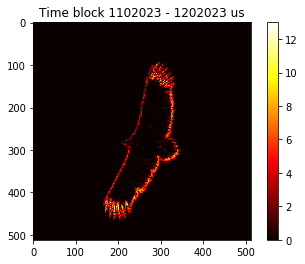

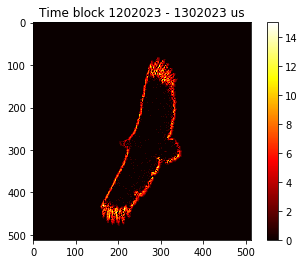

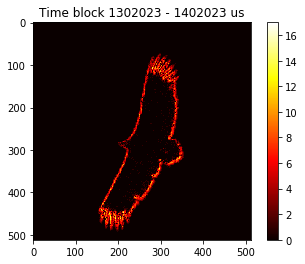

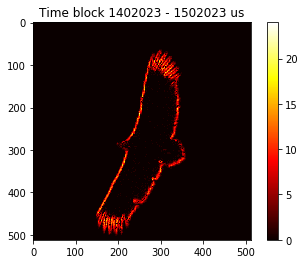

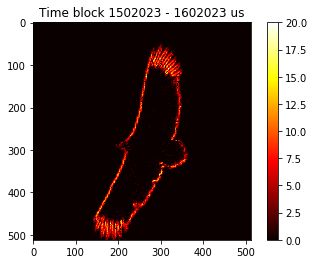

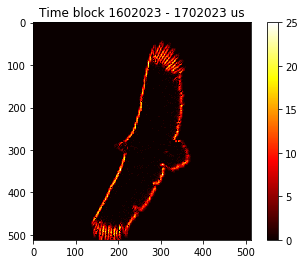

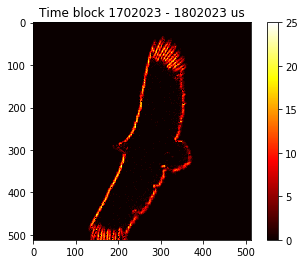

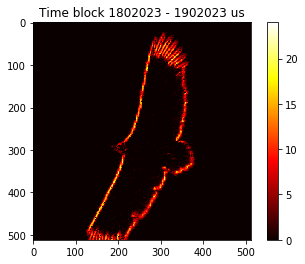

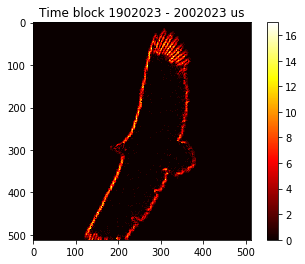

An error occurred while processing Aegypius_monachus_1. The BAG file was not deleted.



In [4]:
bag_root = os.path.expanduser("~/Bags")
spike_root = os.path.expanduser("~/Spikes")

if not os.path.isdir(spike_root):
    os.makedirs(spike_root)
    print(f"Creating folder: {spike_root}")
    
specie = "Aegypius_monachus" # choose a specie from the directory: 
# Ciconia_ciconia, Ciconia_nigra, Aegypius_monachus, Gyps_fulvus, Milvus_milvus, 
# Milvus_migrans, Neophron_percnopterus, Falco_peregrinus, Aquila_chrysaetos, Aquila_adalberti
bird_number = 1 # choose a number between 1 and 400
sequence = f"{specie}_{bird_number}"

specie_path = os.path.join(bag_root, specie)
bag_path = os.path.join(specie_path, sequence)
out_path = os.path.join(bag_path, "out.bag")

if not os.path.isfile(out_path):
    print(f"File not found: {out_path}")

else:
    spike_path = os.path.join(spike_root, specie)
    if not os.path.exists(spike_path):
        os.makedirs(spike_path)
        print(f"Creating folder: {spike_path}")

    aedat_file_name = f"{sequence}.aedat"
    aedat_file_path = os.path.join(spike_path, aedat_file_name)

    if os.path.exists(aedat_file_path):
        print(f"Skipping already processed file: {aedat_file_name}")
    else:
        try:
            b = bagreader(out_path)
            csv_path = b.message_by_topic('/cam0/events')

            if not csv_path or not os.path.isfile(csv_path):
                print(f"No /cam0/events topic in {sequence}")
            else:
                x_coords_np, y_coords_np, timestamps_np, polarities_np = parse_events_from_csv(csv_path)

                hist_by_events = integrate_by_events(x_coords_np, y_coords_np, polarities_np, block_size=50000, img_size=512)
                hist_by_time = integrate_by_time(timestamps_np, x_coords_np, y_coords_np, polarities_np, interval_us=100000, img_size=512)

                addresses = [
                    (x & 0x1FF) | ((y & 0x1FF) << 9) | (int(p) << 18)
                    for x, y, p in zip(x_coords_np, y_coords_np, polarities_np)
                ]
                addresses_np = np.array(addresses, dtype=np.uint32)

                spike_file = SpikesFile(addresses=addresses_np, timestamps=timestamps_np)
                Savers.save_AEDAT(spike_file, os.path.splitext(aedat_file_path)[0], settings, verbose=True)

                if os.path.isfile(aedat_file_path):
                    print(f"Name: {aedat_file_path}")
                    os.remove(out_path) 
                    print(f"Removed BAG file: {out_path}\n")
                else:
                    print(f"Warning: the AEDAT file was not created.\n")

        except Exception as e:
            print(f"An error occurred while processing {sequence}. The BAG file was not deleted.\n")

### Save the events obtained from multiple pictures

The script below converts the whole dataset from BAG files to AEDAT files, without reproducing any of the events.

In [2]:
bag_root = os.path.expanduser("~/Bags")
spike_root = os.path.expanduser("~/Spikes")

if not os.path.isdir(spike_root):
    os.makedirs(spike_root)
    print(f"Creating folder: {spike_root}")

for specie in sorted(os.listdir(bag_root)):
    specie_path = os.path.join(bag_root, specie)
    if not os.path.isdir(specie_path):
        continue

    for sequence in sorted(os.listdir(specie_path)):
        bag_path = os.path.join(specie_path, sequence)
        out_path = os.path.join(bag_path, "out.bag")

        if not os.path.isfile(out_path):
            print(f"File not found: {out_path}")
            continue

        spike_path = os.path.join(spike_root, specie)
        if not os.path.exists(spike_path):
            os.makedirs(spike_path)
            print(f"Creating folder: {spike_path}")

        aedat_file_name = f"{sequence}.aedat"
        aedat_file_path = os.path.join(spike_path, aedat_file_name)

        if os.path.exists(aedat_file_path):
            print(f"Skipping already processed file: {aedat_file_name}")
            continue
            
        try:
            b = bagreader(out_path)
            csv_path = b.message_by_topic('/cam0/events')

            if not csv_path or not os.path.isfile(csv_path):
                print(f"No /cam0/events topic in {sequence}")
                continue

            x_coords_np, y_coords_np, timestamps_np, polarities_np = parse_events_from_csv(csv_path)
            
            addresses = [
                (x & 0x1FF) | ((y & 0x1FF) << 9) | (int(p) << 18)
                for x, y, p in zip(x_coords_np, y_coords_np, polarities_np)
            ]
            addresses_np = np.array(addresses, dtype=np.uint32)
            
            spike_file = SpikesFile(addresses=addresses_np, timestamps=timestamps_np)
            Savers.save_AEDAT(spike_file, os.path.splitext(aedat_file_path)[0], settings, verbose=True)
            
            if os.path.isfile(aedat_file_path):
                print(f"Name: {aedat_file_path}")
                os.remove(out_path) 
                print(f"Removed BAG file: {out_path}\n")
            else:
                print(f"Warning: the AEDAT file was not created.\n")

        except Exception as e:
            print(f"An error occurred while processing {sequence}. The BAG file was not deleted.\n{e}\n")
            
print("All images processed.")

File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_1/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_10/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_100/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_101/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_102/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_103/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_104/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_105/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_106/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_107/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_108/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_109/out.bag
File not found: /home/asia/Bags/Aegypius_mo

File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_197/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_198/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_199/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_2/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_20/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_200/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_201/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_202/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_203/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_204/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_205/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_206/out.bag
File not found: /home/asia/Bags/Aegypius_mo

File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_312/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_313/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_314/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_315/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_316/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_317/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_318/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_319/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_32/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_320/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_321/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_322/out.bag
File not found: /home/asia/Bags/Aegypius_

File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_46/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_47/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_48/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_49/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_5/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_50/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_51/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_52/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_53/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_54/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_55/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aegypius_monachus_56/out.bag
File not found: /home/asia/Bags/Aegypius_monachus/Aeg

File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_176/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_177/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_178/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_179/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_18/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_180/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_181/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_182/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_183/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_184/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_185/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_186/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti

File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_322/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_323/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_324/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_325/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_326/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_327/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_328/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_329/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_33/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_330/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_331/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_332/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti

File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_63/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_64/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_65/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_66/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_67/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_68/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_69/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_7/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_70/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_71/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_72/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_73/out.bag
File not found: /home/asia/Bags/Aquila_adalberti/Aquila_adalberti_74/out.bag


AEDAT file saved correctly.Took: 0.35028624534606934 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_113.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_113/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_114/out.
AEDAT file saved correctly.Took: 0.46317625045776367 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_114.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_114/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_115/out.
AEDAT file saved correctly.Took: 0.6743295192718506 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_115.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_115/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_116/out.
AEDAT file saved correctly.Took: 1.869527

AEDAT file saved correctly.Took: 0.4383385181427002 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_137.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_137/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_138/out.
AEDAT file saved correctly.Took: 0.7980082035064697 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_138.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_138/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_139/out.
AEDAT file saved correctly.Took: 0.49688029289245605 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_139.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_139/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_14/out.
AEDAT file saved correctly.Took: 1.23255681

AEDAT file saved correctly.Took: 0.8289127349853516 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_160.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_160/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_161/out.
AEDAT file saved correctly.Took: 0.6725504398345947 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_161.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_161/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_162/out.
AEDAT file saved correctly.Took: 0.8464455604553223 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_162.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_162/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_163/out.
AEDAT file saved correctly.Took: 0.39668774

AEDAT file saved correctly.Took: 0.40491747856140137 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_184.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_184/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_185/out.
AEDAT file saved correctly.Took: 1.4650919437408447 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_185.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_185/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_186/out.
AEDAT file saved correctly.Took: 0.15037059783935547 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_186.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_186/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_187/out.
AEDAT file saved correctly.Took: 0.417754

AEDAT file saved correctly.Took: 7.769217491149902 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_207.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_207/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_208/out.
AEDAT file saved correctly.Took: 8.199338912963867 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_208.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_208/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_209/out.
AEDAT file saved correctly.Took: 11.387448072433472 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_209.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_209/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_21/out.
AEDAT file saved correctly.Took: 1.52796220779

AEDAT file saved correctly.Took: 0.06250429153442383 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_230.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_230/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_231/out.
AEDAT file saved correctly.Took: 0.23599481582641602 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_231.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_231/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_232/out.
AEDAT file saved correctly.Took: 0.2449803352355957 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_232.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_232/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_233/out.
AEDAT file saved correctly.Took: 0.145163

AEDAT file saved correctly.Took: 0.29583191871643066 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_254.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_254/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_255/out.
AEDAT file saved correctly.Took: 0.6982879638671875 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_255.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_255/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_256/out.
AEDAT file saved correctly.Took: 0.08135151863098145 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_256.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_256/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_257/out.
AEDAT file saved correctly.Took: 0.143239

AEDAT file saved correctly.Took: 0.4516737461090088 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_278.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_278/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_279/out.
AEDAT file saved correctly.Took: 0.4192636013031006 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_279.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_279/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_28/out.
AEDAT file saved correctly.Took: 0.6204812526702881 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_28.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_28/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_280/out.
AEDAT file saved correctly.Took: 0.53797602653

AEDAT file saved correctly.Took: 0.41638946533203125 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_300.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_300/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_301/out.
AEDAT file saved correctly.Took: 0.4768035411834717 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_301.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_301/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_302/out.
AEDAT file saved correctly.Took: 0.18976616859436035 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_302.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_302/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_303/out.
AEDAT file saved correctly.Took: 0.340947

AEDAT file saved correctly.Took: 0.9283549785614014 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_324.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_324/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_325/out.
AEDAT file saved correctly.Took: 1.574223279953003 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_325.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_325/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_326/out.
AEDAT file saved correctly.Took: 1.4577784538269043 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_326.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_326/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_327/out.
AEDAT file saved correctly.Took: 1.645923614

AEDAT file saved correctly.Took: 0.42047572135925293 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_348.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_348/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_349/out.
AEDAT file saved correctly.Took: 0.4201023578643799 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_349.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_349/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_35/out.
AEDAT file saved correctly.Took: 0.7361898422241211 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_35.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_35/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_350/out.
AEDAT file saved correctly.Took: 0.2154161930

AEDAT file saved correctly.Took: 0.18738222122192383 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_371.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_371/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_372/out.
AEDAT file saved correctly.Took: 0.5107214450836182 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_372.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_372/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_373/out.
AEDAT file saved correctly.Took: 0.3528718948364258 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_373.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_373/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_374/out.
AEDAT file saved correctly.Took: 0.3497695

AEDAT file saved correctly.Took: 0.1947004795074463 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_395.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_395/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_396/out.
AEDAT file saved correctly.Took: 0.5502433776855469 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_396.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_396/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_397/out.
AEDAT file saved correctly.Took: 0.21169567108154297 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_397.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_397/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_398/out.
AEDAT file saved correctly.Took: 0.0908098

AEDAT file saved correctly.Took: 0.9677159786224365 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_58.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_58/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_59/out.
AEDAT file saved correctly.Took: 1.5672366619110107 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_59.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_59/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_6/out.
AEDAT file saved correctly.Took: 0.45702576637268066 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_6.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_6/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_60/out.
AEDAT file saved correctly.Took: 0.5822184085845947 se

AEDAT file saved correctly.Took: 0.22174859046936035 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_81.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_81/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_82/out.
AEDAT file saved correctly.Took: 0.7690668106079102 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_82.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_82/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_83/out.
AEDAT file saved correctly.Took: 0.40746188163757324 seconds
Name: /home/asia/Spikes/Aquila_chrysaetos/Aquila_chrysaetos_83.aedat
Removed BAG file: /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_83/out.bag

[INFO]  Successfully created the data folder /home/asia/Bags/Aquila_chrysaetos/Aquila_chrysaetos_84/out.
AEDAT file saved correctly.Took: 0.393596172332763